In [ ]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U statsmodels
!pip install -U pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import pmdarima as pm

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Traffic.xlsx')


In [ ]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3401-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

In [ ]:
df_filter['1st_diff']=df_filter['DL user tput'].diff(96)
df_filter['1st_diff'].fillna(df_filter['1st_diff'].median(),inplace=True)

In [ ]:
df_filter['2nd_diff'] = df_filter['1st_diff'].diff()
df_filter['2nd_diff'].fillna(df_filter['2nd_diff'].median(),inplace=True)

In [ ]:

def gridsearcharima(AR,d,MA,SAR,SD,SMA,m=96,debug=False):
    """ 
    walk-forward implementation for SARIMA with RMSE as selection metric
    """
    errors=[]
    seen_last=False
    steps_completed=0
    
    #run the below for loop for each combination of parameters. First we use Samtest to do the train/test
    #split for each step
    
    for end_of_train in range(Samtest, len(df_filter)-h+1):
        train=df_filter.iloc[:end_of_train]
        test=df_filter.iloc[end_of_train:end_of_train+h]
        
        if test.index[-1]==df_filter.index[-1]:
            seen_last=True
            
        steps_completed +=1
        
        #HW model trained for every train set split for each set of parameters
        
        
        arima=ARIMA(train['DL user tput'],order=(AR,d,MA),seasonal_order=(SAR,SD,SMA,m))
        arima_result=arima.fit()

        
        prediction_result=arima_result.get_forecast(h)
        forecast=prediction_result.predicted_mean
        #df.loc[test_idx,'AR(1)']=forecast
        
        #forecasts generated and MSE is calculated everytime and appended to a list
        #fcast=res_hw.forecast(h)
        error=np.sqrt(mean_squared_error(test['DL user tput'],forecast))
        #error=0.5
        #error=r2_score(test['DL user tput'],fcast)
        errors.append(error)
        
        if debug:
            print("seen last:",seen_last)
            print("steps completed:",steps_completed)
        
        #the mean MSE is returned from the function
    return errors

In [ ]:
#walkforward(1,1,1,0,0,0,0,debug=False)

h=96
steps=1
Samtest=len(df_filter)-h-steps+1


AR_list=[1]
d_list=[1]
MA_list=[1]
SAR_list=[1,2]
SD_list=[1]
SMA_list=[1]

tupe_of_option_lists=(
    AR_list,
    d_list,
    MA_list,
    SAR_list,
    SD_list,
    SMA_list

)


best_score=float('inf')
best_options=None

#itertools used to input the tuple of parameters to the walk-forward function.

for x in itertools.product(*tupe_of_option_lists):
    score=gridsearcharima(*x)
    
    #Best score is updated based on the mean MSE returned from walkforward function as well as the best params
    if np.mean(score) < best_score:
        print("Best score so far:",score)
        best_score=np.mean(score)
        best_options=x
        print("Best params so far:",best_options)


In [ ]:
df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_2786_2']

In [ ]:

df_filter.index

#df_filter['Start Time'] = pd.to_datetime(df_filter['Start Time'])   
#df_filter.set_index('Start Time',inplace=True)

NameError: ignored

In [ ]:
df_filter[['L.Traffic.User.ULData.Avg (None)','L.Traffic.User.DLData.Avg (None)']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


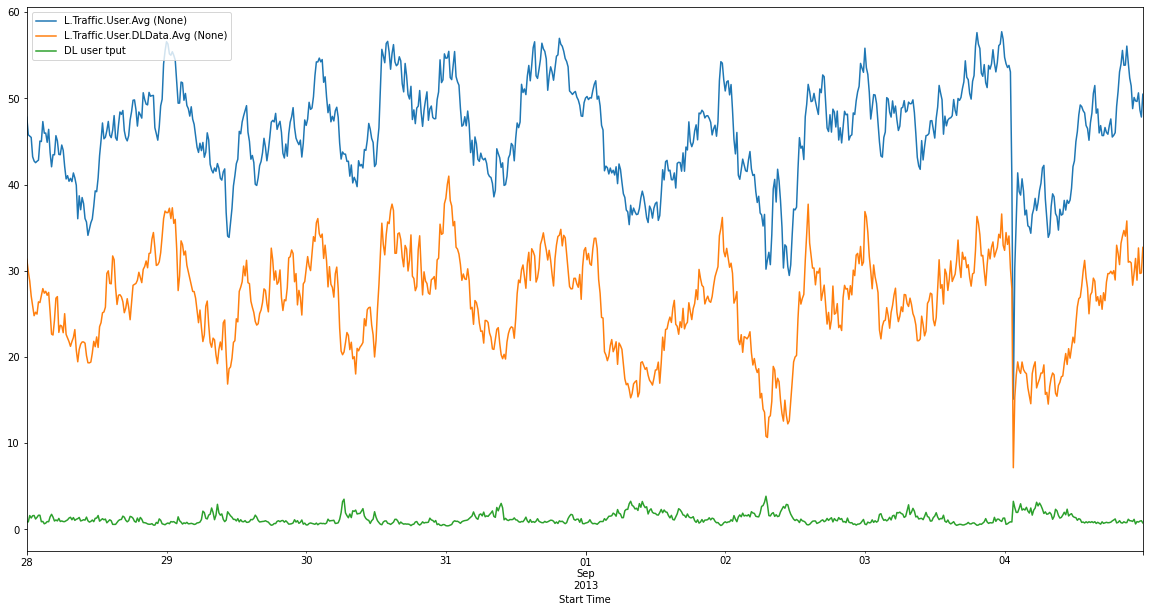

In [ ]:

df_filter['DL user tput']=df_filter['L.Thrp.bits.DL.QCI.9 (bit)']/(df_filter['L.Thrp.Time.DL.QCI.9 (ms)']*1000)

df_filter['DL cell tput']=df_filter['L.Thrp.bits.DL (bit)']/(df_filter['L.Thrp.Time.Cell.DL (s)']*1000)

df_filter[['L.Thrp.bits.DL.QCI.9 (bit)','L.Thrp.Time.DL.QCI.9 (ms)','DL user tput']]

df_filter[['L.Traffic.User.Avg (None)','L.Traffic.User.DLData.Avg (None)','DL user tput']].plot(figsize=(20,10))

In [ ]:
df.columns

Index(['Start Time', 'Cell', 'L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.QPSK.TB (None)',
       'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
       'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
       'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
       'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
       'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)', 'DL RBLER (%)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 